# Modeling

## Objective
Train and evaluate multiple classification models to predict video game hits (total_sales >= 1M).

## Models
1. Logistic Regression (baseline linear classifier)
2. Decision Tree
3. Random Forest
4. K-Nearest Neighbors (KNN)

## Evaluation
- Cross-validation
- Hyperparameter tuning with GridSearchCV
- Multiple metrics: Accuracy, Precision, Recall, F1-Score, ROC-AUC


In [ ]:
%%sql


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)


## 1. Load Preprocessed Data


In [11]:
# Load training and test sets
X_train = pd.read_csv('../data/processed/X_train.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')
y_train = pd.read_csv('../data/processed/y_train.csv').values.ravel()
y_test = pd.read_csv('../data/processed/y_test.csv').values.ravel()

# Load scaled versions (for models that need scaling)
X_train_scaled = pd.read_csv('../data/processed/X_train_scaled.csv')
X_test_scaled = pd.read_csv('../data/processed/X_test_scaled.csv')

# Load class weights
class_weights_df = pd.read_csv('../data/processed/class_weights.csv')
# Convert string keys to int keys
class_weights = {int(k): v for k, v in class_weights_df.to_dict('records')[0].items()}

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Class weights: {class_weights}")
print(f"\nTarget distribution in training:")
print(pd.Series(y_train).value_counts())


Training set: (11790, 57)
Test set: (2948, 57)
Class weights: {0: 0.5557126696832579, 1: 4.98730964467005}

Target distribution in training:
0    10608
1     1182
Name: count, dtype: int64


## 2. Baseline Models (Without Tuning)


In [19]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# Store results
baseline_results = []

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Training Baseline Models...")
print("="*80)

for name, model in models.items():
    print(f"\n{name}:")

    # Use scaled data for Logistic Regression and KNN
    if name in ['Logistic Regression', 'KNN']:
        X_tr, X_te = X_train_scaled, X_test_scaled
    else:
        X_tr, X_te = X_train, X_test

    # Cross-validation scores
    cv_scores = cross_val_score(model, X_tr, y_train, cv=cv, scoring='f1')

    # Train on full training set
    model.fit(X_tr, y_train)

    # Predictions
    y_pred = model.predict(X_te)
    y_pred_proba = model.predict_proba(X_te)[:, 1] if hasattr(model, 'predict_proba') else y_pred

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    baseline_results.append({
        'Model': name,
        'CV F1 Mean': cv_scores.mean(),
        'CV F1 Std': cv_scores.std(),
        'Test Accuracy': accuracy,
        'Test Precision': precision,
        'Test Recall': recall,
        'Test F1': f1,
        'Test ROC-AUC': roc_auc
    })

    print(f"  CV F1: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"  Test Accuracy: {accuracy:.4f}")
    print(f"  Test Precision: {precision:.4f}")
    print(f"  Test Recall: {recall:.4f}")
    print(f"  Test F1: {f1:.4f}")
    print(f"  Test ROC-AUC: {roc_auc:.4f}")

# Display results table
baseline_df = pd.DataFrame(baseline_results)
print("\n" + "="*80)
print("BASELINE RESULTS SUMMARY")
print("="*80)
print(baseline_df.to_string(index=False))


Training Baseline Models...

Logistic Regression:
  CV F1: 0.3556 (+/- 0.0056)
  Test Accuracy: 0.7429
  Test Precision: 0.2402
  Test Recall: 0.7254
  Test F1: 0.3609
  Test ROC-AUC: 0.8286

Decision Tree:
  CV F1: 0.5596 (+/- 0.0264)
  Test Accuracy: 0.9166
  Test Precision: 0.5836
  Test Recall: 0.5797
  Test F1: 0.5816
  Test ROC-AUC: 0.7668

Random Forest:
  CV F1: 0.5460 (+/- 0.0229)
  Test Accuracy: 0.9352
  Test Precision: 0.8421
  Test Recall: 0.4339
  Test F1: 0.5727
  Test ROC-AUC: 0.9454

KNN:
  CV F1: 0.3533 (+/- 0.0312)
  Test Accuracy: 0.9013
  Test Precision: 0.5141
  Test Recall: 0.2475
  Test F1: 0.3341
  Test ROC-AUC: 0.7882

BASELINE RESULTS SUMMARY
              Model  CV F1 Mean  CV F1 Std  Test Accuracy  Test Precision  Test Recall  Test F1  Test ROC-AUC
Logistic Regression    0.355574   0.005593       0.742877        0.240180     0.725424 0.360877      0.828584
      Decision Tree    0.559614   0.026443       0.916554        0.583618     0.579661 0.581633      0

## 3. Visualize Baseline Results


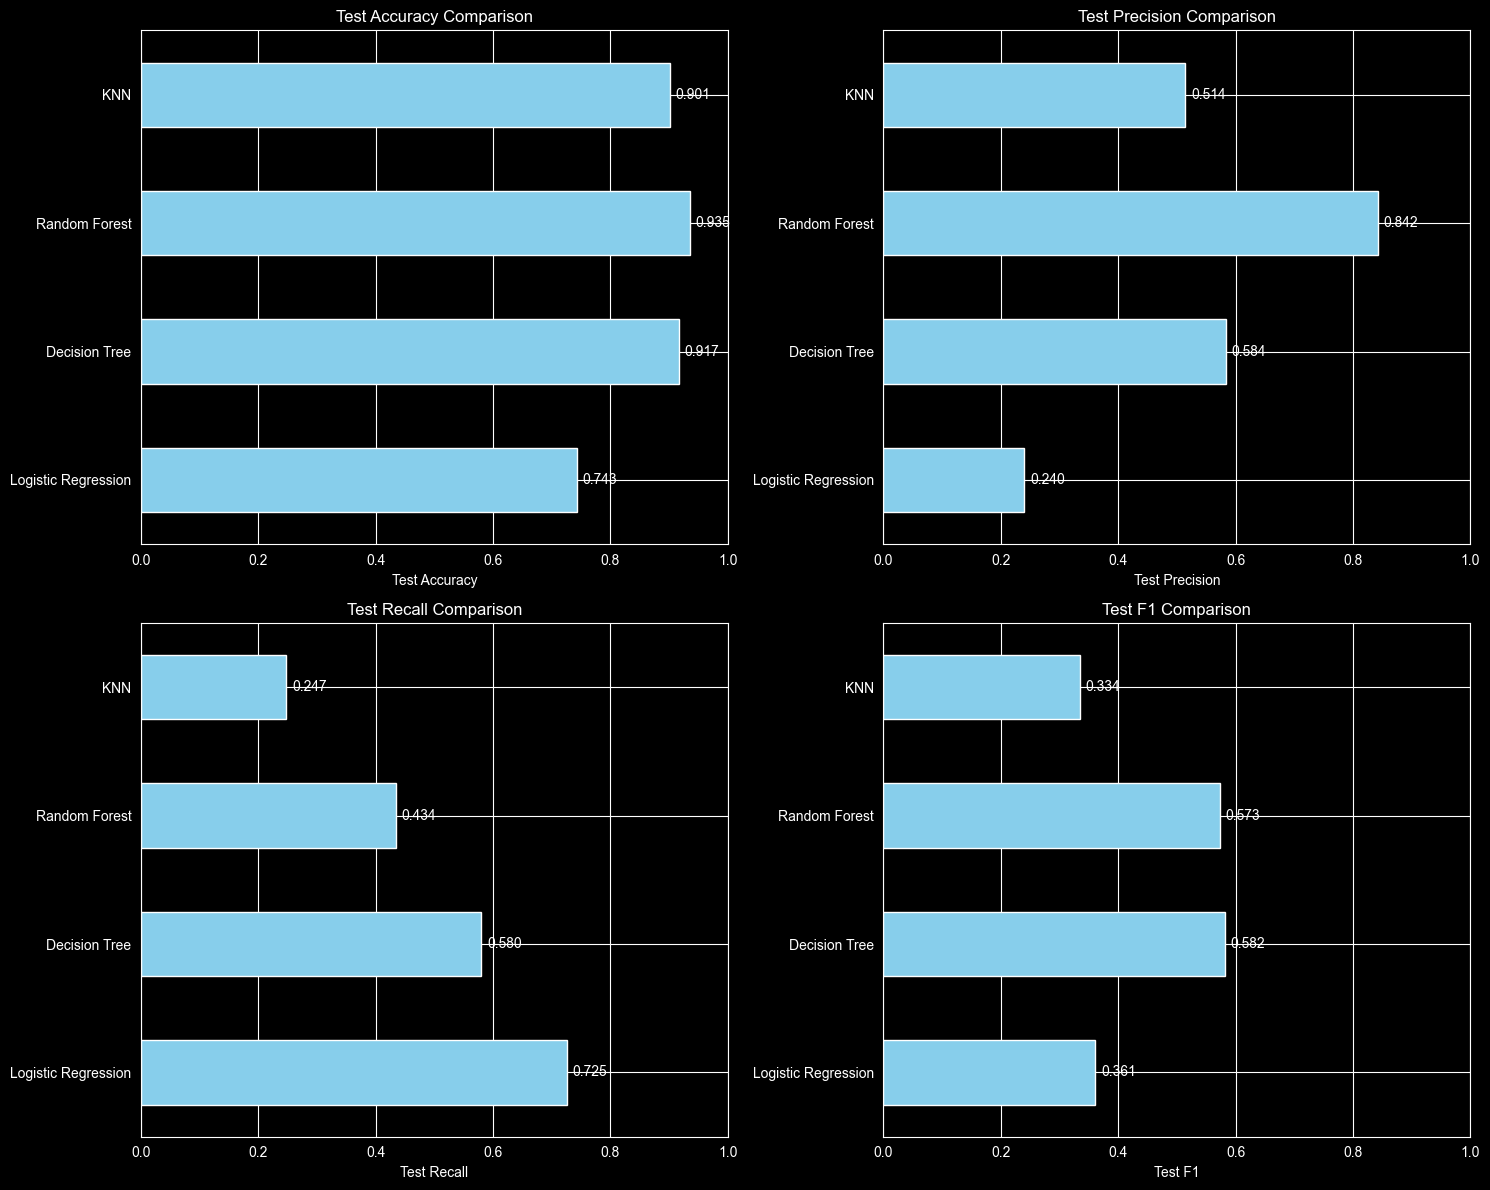

<Figure size 1000x600 with 0 Axes>

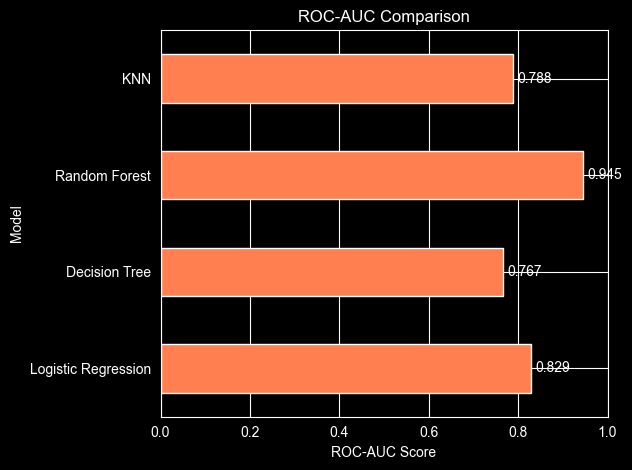

In [13]:
# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

metrics = ['Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    baseline_df.plot(x='Model', y=metric, kind='barh', ax=ax, legend=False, color='skyblue')
    ax.set_xlabel(metric)
    ax.set_ylabel('')
    ax.set_title(f'{metric} Comparison')
    ax.set_xlim([0, 1])

    # Add value labels
    for i, v in enumerate(baseline_df[metric]):
        ax.text(v + 0.01, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.show()

# ROC-AUC comparison
plt.figure(figsize=(10, 6))
baseline_df.plot(x='Model', y='Test ROC-AUC', kind='barh', legend=False, color='coral')
plt.xlabel('ROC-AUC Score')
plt.title('ROC-AUC Comparison')
plt.xlim([0, 1])
for i, v in enumerate(baseline_df['Test ROC-AUC']):
    plt.text(v + 0.01, i, f'{v:.3f}', va='center')
plt.tight_layout()
plt.show()


## 4. Hyperparameter Tuning


In [14]:
# Define parameter grids
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'solver': ['lbfgs', 'liblinear']
    },
    'Decision Tree': {
        'max_depth': [5, 10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }
}

# Perform grid search
tuned_models = {}
tuned_results = []

print("Hyperparameter Tuning with GridSearchCV...")
print("="*80)

for name, model in models.items():
    print(f"\n{name}:")

    # Use scaled data for Logistic Regression and KNN
    if name in ['Logistic Regression', 'KNN']:
        X_tr, X_te = X_train_scaled, X_test_scaled
    else:
        X_tr, X_te = X_train, X_test

    # Grid search
    grid_search = GridSearchCV(
        model,
        param_grids[name],
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        verbose=0
    )

    grid_search.fit(X_tr, y_train)

    # Best model
    best_model = grid_search.best_estimator_
    tuned_models[name] = best_model

    print(f"  Best parameters: {grid_search.best_params_}")
    print(f"  Best CV F1: {grid_search.best_score_:.4f}")

    # Test predictions
    y_pred = best_model.predict(X_te)
    y_pred_proba = best_model.predict_proba(X_te)[:, 1] if hasattr(best_model, 'predict_proba') else y_pred

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    tuned_results.append({
        'Model': name,
        'Best CV F1': grid_search.best_score_,
        'Test Accuracy': accuracy,
        'Test Precision': precision,
        'Test Recall': recall,
        'Test F1': f1,
        'Test ROC-AUC': roc_auc
    })

    print(f"  Test Accuracy: {accuracy:.4f}")
    print(f"  Test Precision: {precision:.4f}")
    print(f"  Test Recall: {recall:.4f}")
    print(f"  Test F1: {f1:.4f}")
    print(f"  Test ROC-AUC: {roc_auc:.4f}")

# Display tuned results
tuned_df = pd.DataFrame(tuned_results)
print("\n" + "="*80)
print("TUNED RESULTS SUMMARY")
print("="*80)
print(tuned_df.to_string(index=False))


Hyperparameter Tuning with GridSearchCV...

Logistic Regression:
  Best parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
  Best CV F1: 0.3576
  Test Accuracy: 0.7503
  Test Precision: 0.2474
  Test Recall: 0.7322
  Test F1: 0.3699
  Test ROC-AUC: 0.8279

Decision Tree:
  Best parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
  Best CV F1: 0.5709
  Test Accuracy: 0.9108
  Test Precision: 0.5513
  Test Recall: 0.5831
  Test F1: 0.5667
  Test ROC-AUC: 0.7690

Random Forest:
  Best parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
  Best CV F1: 0.6264
  Test Accuracy: 0.9362
  Test Precision: 0.6851
  Test Recall: 0.6712
  Test F1: 0.6781
  Test ROC-AUC: 0.9456

KNN:
  Best parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
  Best CV F1: 0.4404
  Test Accuracy: 0.9088
  Test Precision: 0.5637
  Test Recall: 0.3898
  Test F1: 0.4609
  Test ROC-AUC: 0.7858

## 5. Compare Baseline vs Tuned


Baseline vs Tuned Model Comparison:
              Model  Test F1_Baseline  Test F1_Tuned  Improvement
Logistic Regression          0.360877       0.369863     0.008986
      Decision Tree          0.581633       0.566722    -0.014911
      Random Forest          0.572707       0.678082     0.105375
                KNN          0.334096       0.460922     0.126826


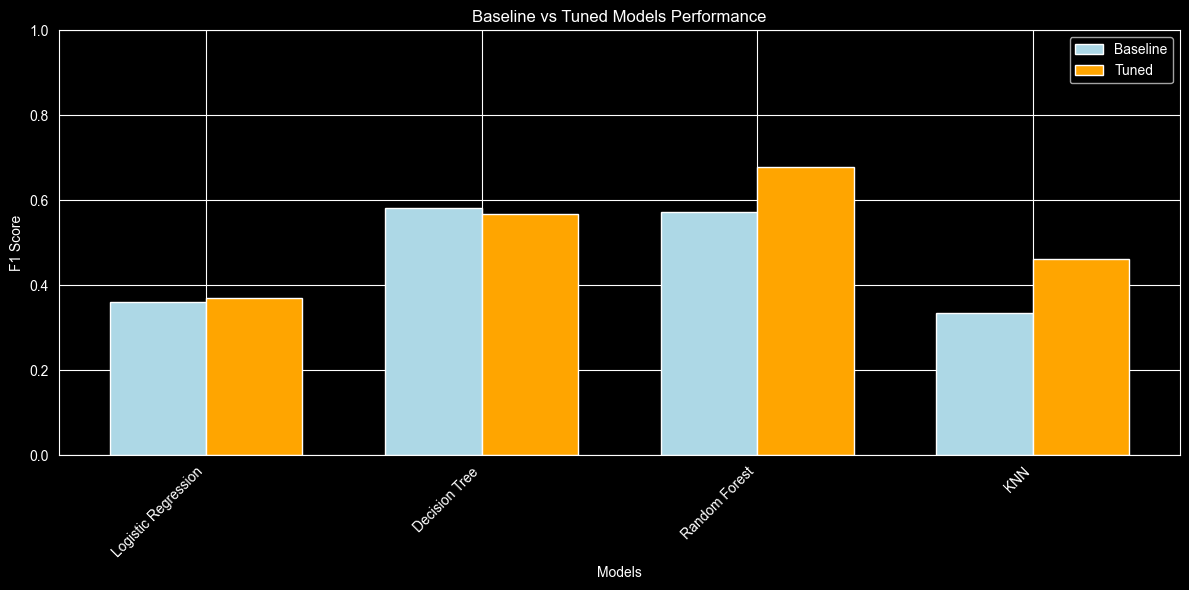

In [15]:
# Comparison
comparison = baseline_df[['Model', 'Test F1']].merge(
    tuned_df[['Model', 'Test F1']],
    on='Model',
    suffixes=('_Baseline', '_Tuned')
)
comparison['Improvement'] = comparison['Test F1_Tuned'] - comparison['Test F1_Baseline']

print("Baseline vs Tuned Model Comparison:")
print(comparison.to_string(index=False))

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(comparison))
width = 0.35

ax.bar(x - width/2, comparison['Test F1_Baseline'], width, label='Baseline', color='lightblue')
ax.bar(x + width/2, comparison['Test F1_Tuned'], width, label='Tuned', color='orange')

ax.set_xlabel('Models')
ax.set_ylabel('F1 Score')
ax.set_title('Baseline vs Tuned Models Performance')
ax.set_xticks(x)
ax.set_xticklabels(comparison['Model'], rotation=45, ha='right')
ax.legend()
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()


## 6. Best Model Analysis


Best Model: Random Forest
Best F1 Score: 0.6781


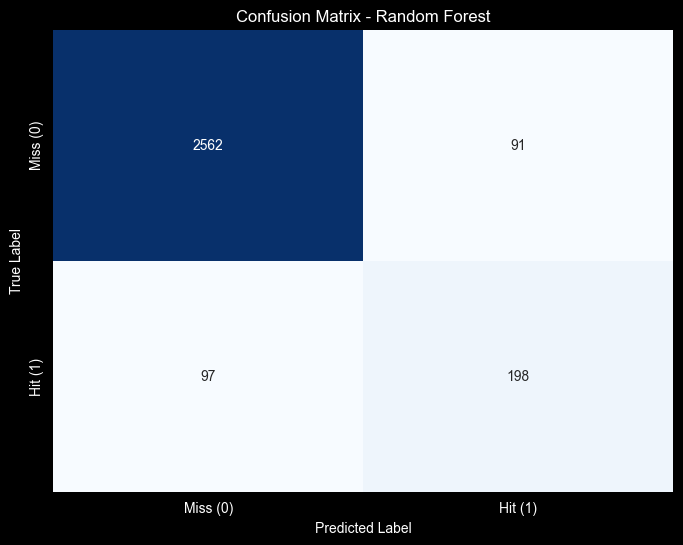


Classification Report:
              precision    recall  f1-score   support

        Miss       0.96      0.97      0.96      2653
         Hit       0.69      0.67      0.68       295

    accuracy                           0.94      2948
   macro avg       0.82      0.82      0.82      2948
weighted avg       0.94      0.94      0.94      2948



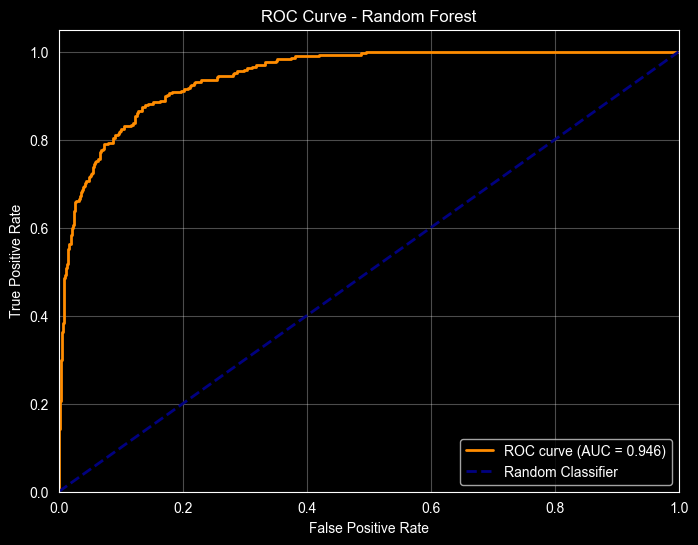

In [16]:
# Select best model based on F1 score
best_model_name = tuned_df.loc[tuned_df['Test F1'].idxmax(), 'Model']
best_model = tuned_models[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"Best F1 Score: {tuned_df['Test F1'].max():.4f}")

# Use appropriate data
if best_model_name in ['Logistic Regression', 'KNN']:
    X_test_final = X_test_scaled
else:
    X_test_final = X_test

# Predictions
y_pred_best = best_model.predict(X_test_final)
y_pred_proba_best = best_model.predict_proba(X_test_final)[:, 1] if hasattr(best_model, 'predict_proba') else y_pred_best

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks([0.5, 1.5], ['Miss (0)', 'Hit (1)'])
plt.yticks([0.5, 1.5], ['Miss (0)', 'Hit (1)'])
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['Miss', 'Hit']))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_best)
roc_auc = roc_auc_score(y_test, y_pred_proba_best)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_model_name}')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


## 7. Feature Importance (for tree-based models)


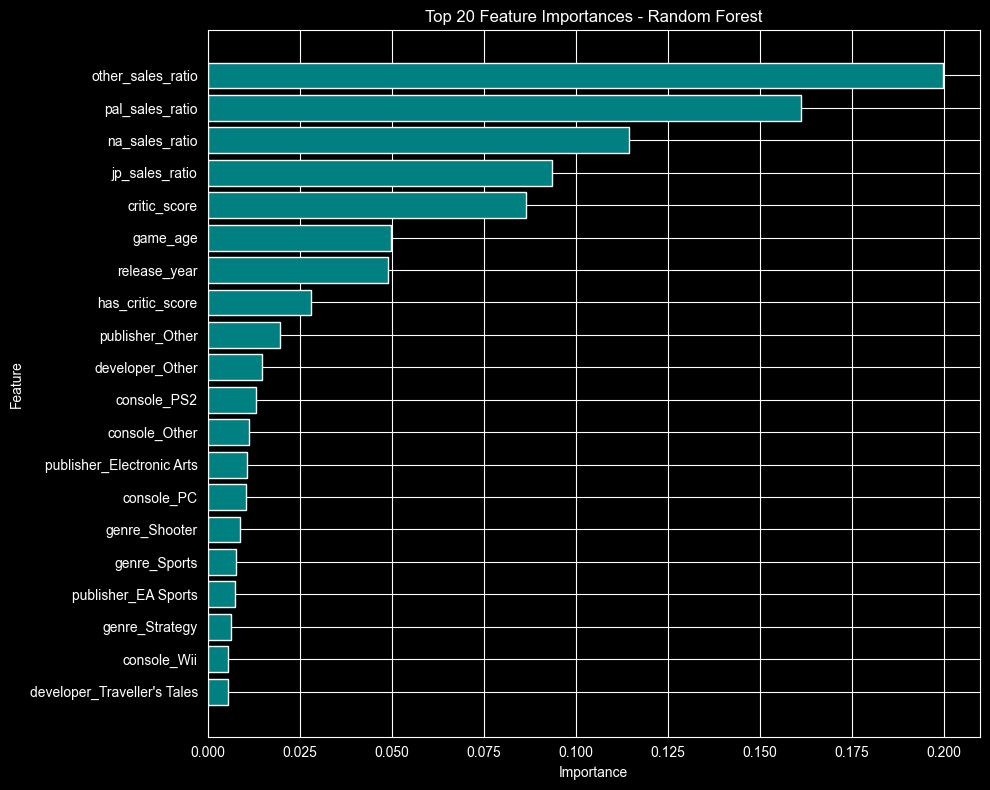

Top 20 Most Important Features:
                    Feature  Importance
          other_sales_ratio    0.199870
            pal_sales_ratio    0.161149
             na_sales_ratio    0.114562
             jp_sales_ratio    0.093496
               critic_score    0.086502
                   game_age    0.049715
               release_year    0.049120
           has_critic_score    0.028186
            publisher_Other    0.019662
            developer_Other    0.014913
                console_PS2    0.013196
              console_Other    0.011205
  publisher_Electronic Arts    0.010850
                 console_PC    0.010327
              genre_Shooter    0.008694
               genre_Sports    0.007775
        publisher_EA Sports    0.007421
             genre_Strategy    0.006244
                console_Wii    0.005610
developer_Traveller's Tales    0.005524


In [17]:
if best_model_name in ['Decision Tree', 'Random Forest']:
    # Get feature importances
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        feature_names = X_train.columns

        # Create dataframe
        feature_imp_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False).head(20)

        # Plot
        plt.figure(figsize=(10, 8))
        plt.barh(feature_imp_df['Feature'], feature_imp_df['Importance'], color='teal')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.title(f'Top 20 Feature Importances - {best_model_name}')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

        print("Top 20 Most Important Features:")
        print(feature_imp_df.to_string(index=False))
else:
    print(f"Feature importance not available for {best_model_name}")


## 8. Save Best Model


In [ ]:
import joblib

# Save best model
model_path = '../models/best_model.pkl'
joblib.dump(best_model, model_path)
print(f"Best model ({best_model_name}) saved to: {model_path}")

# Save all tuned models
for name, model in tuned_models.items():
    safe_name = name.replace(' ', '_').lower()
    model_path = f'../models/{safe_name}_tuned.pkl'
    joblib.dump(model, model_path)
    print(f"{name} saved to: {model_path}")

# Save results
baseline_df.to_csv('../models/baseline_results.csv', index=False)
tuned_df.to_csv('../models/tuned_results.csv', index=False)
print("\nResults saved to models directory")
